In [1]:
import yt
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib import colormaps
import scipy
import pandas as pd
import os
import glob
from astropy.cosmology import FlatLambdaCDM
import pickle
import trident

In [2]:
def read_info(RamsesDir, timestep, alt_path=None):
    """ Returns info from the simulation (dict). """
    #savepath = get_alt_path(RamsesDir, alt_path=alt_path)
    #check_ratapath(savepath)
    savepath = RamsesDir
    path_info = f'{savepath}/ratadat/info_dict.pkl'
    if not os.path.exists(path_info):                # If first time, save general data
        info_dict = read_info_glob(RamsesDir, timestep=timestep)
        with open(path_info, 'wb') as file: 
            pickle.dump({'00000': info_dict}, file)
    with open(path_info, 'rb') as file:              # Otherwise, load common data
        all_info = pickle.load(file)
        info_dict = all_info.get('00000', {}).copy() # Important to copy, otherwise '00000' will be modified
        if timestep != 0:
            t_group = f'{timestep:05d}'
            if t_group in all_info:                  # And add timestep specific data.
                info_dict = all_info[t_group]
            else:
                info_dict = read_info_tstep(RamsesDir, timestep, info_dict)
                all_info[t_group] = info_dict
                with open(path_info, 'wb') as file:
                    pickle.dump(all_info, file)
    return info_dict


def read_info_glob(RamsesDir, timestep=1):
    """ Read info parameters common to all timesteps of a given simulation. """
    tstep = f'{timestep:05d}'
    path_out = f'{RamsesDir}/output_{tstep}/'
    
    # Initialise some variables which might not be defined.
    info_dict = {}
    info_dict['new_format'] = get_format(f'{path_out}header_{tstep}.txt')                     # Get whether post-2017 or not
    for key in ['isH2', 'delayed_cooling', 'momentum_feedback']:
        info_dict[key] = False

    # Namelist
    info_dict  = param2dict(info_dict, get_nml(RamsesDir, timestep))                                    # Namelist
    info_dict  = param2dict(info_dict, f'{path_out}info_rt_{tstep}.txt')                                # info_rt_xxxxx.txt
    info_dict  = hydro2dict(info_dict, f'{path_out}hydro_file_descriptor.txt', info_dict['new_format']) # hydro_file_descriptor
    info_dict  = get_nvar  (info_dict, path_out, tstep)                                                 # (after hydro2dict)

    # Corrections
    info_dict['X_fraction'] = round(info_dict['X_fraction'], 6) # Correct precision error in info_rt_xxxxx.txt
    info_dict['Y_fraction'] = round(info_dict['Y_fraction'], 6)

    # Determine simulation type
    # Note: original way is the following BUT have to read info_xxxxx.txt (resp header_xxx.txt), and some variables there depends on timestep
    #       info_dict['is_cosmo'] = info_dict['omega_m']!=1.0 and info_dict['aexp']!=1 and info_dict['H0']!=1 
    #       info_dict['is_zoom']  = info_dict['is_cosmo'] and info_dict['ndm'] != (2*info_dict['levelmin'])*info_dict['ndim']
    info_dict['is_cosmo'] = info_dict['cosmo']
    info_dict['is_zoom']  = info_dict['is_cosmo'] and 'initfile(2)' in info_dict
    info_dict['is_cool_refine'] = 'cooling_refine' in info_dict and any(value != -1 for value in info_dict['cooling_refine'])
    info_dict['nvarnoadvect'] = info_dict['cooling_time_ivar'] if info_dict['is_cool_refine'] else 0

    return info_dict


def read_info_tstep(RamsesDir, timestep, info_dict):
    """ Read info parameters for a given timestep anc add some units. """
    tstep = f'{timestep:05d}'
    path_out = f'{RamsesDir}/output_{tstep}/'
    info_dict  = param2dict(info_dict, f'{path_out}info_{tstep}.txt')               # info_xxxxx.txt
    info_dict  = headr2dict(info_dict, f'{path_out}header_{tstep}.txt', info_dict['new_format']) # header_xxxxx.txt

    # Units
    info_dict['unit_m']      = info_dict['unit_d']*info_dict['unit_l']**3
    info_dict['unit_v']      = info_dict['unit_l']/info_dict['unit_t']
    info_dict['unit_P']      = info_dict['unit_d']*info_dict['unit_v']**2
    info_dict['unit_T2']     = mH/kB*info_dict['unit_v']**2
    info_dict['unit_nH']     = info_dict['X_fraction']*info_dict['unit_d']/mH
    info_dict['unit_nHe']    = info_dict['unit_nH'] * info_dict['Y_fraction']/info_dict['X_fraction'] * 0.25
    info_dict['cu2cm']       = info_dict['unit_l'] * info_dict['boxlen']
    info_dict['boxlen_cMpc'] = info_dict['boxlen']*info_dict['unit_l']/info_dict['aexp']/kpc2cm/1e3 if info_dict['is_cosmo'] else None
    info_dict['redshift']    = 1./info_dict['aexp']-1
    info_dict['t_myr']       = info_dict['time']*info_dict['unit_t']/Myr2s if not info_dict['is_cosmo']\
        else FlatLambdaCDM(H0=info_dict['H0'],Om0=info_dict['omega_m']).age(1/info_dict['aexp']-1).value*1e3
    return info_dict


def get_nml(RamsesDir, timestep):
    """Return the path to the nml."""
    # Check the output directory
    path_nml = f'{RamsesDir}/output_{timestep:05d}/namelist.txt'    
    if os.access(path_nml, os.R_OK):            # Check it's readable
        with open(path_nml, 'r') as file:
            for line in file:
                if '&RUN_PARAMS' in line:       
                    return path_nml
    # If the file is doesn't exist/is corrupted, check the RamsesDir
    nml_files = glob.glob(f"{RamsesDir}/*.nml")
    path_nml = next((f for f in nml_files if os.access(f, os.R_OK)), None) # First nml with read access
    if path_nml is None:
        raise Exception(f"No accessible .nml file found in {RamsesDir}.")
    return path_nml


def headr2dict(info_dict, file_path, new_format):
    """ Add header variables (i.e. number of particles and particle fields) to info_dict. """
    header = {
        "Total number of particles": "npart",       # Old format
        "Total number of dark matter particles": "ndm",
        "Total number of star particles": "nstar",
        "Total number of sink particles": "nsink",
        "DM": "ndm",                                # New format
        "star": "nstar",
    }
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if "Particle fields" in line:
                info_dict["particle_fields"] = next(file).strip().split()
                break  # No more info after particle fields
            parts = line.split()
            if new_format and len(parts) == 2 and parts[0] in header:
                info_dict[header[parts[0]]] = int(parts[1])
            elif not new_format and 'Total' in line:
                info_dict[header[line]] = int(next(file).strip())
    return info_dict


def hydro2dict(info_dict, path_hydrofd, new_format):
    """ Read hydro_file_descriptor and add the indexes of the hydro parameters to info_dict. """
    with open(path_hydrofd, 'r') as file:
        for line in file:
            line = line.strip()
            if not line.startswith('#'): # skip the first in new format
                parts = line.split(',') if new_format else line.replace('#', ':').split(':')
                index1, index2 = (0, 1) if new_format else (-2, -1)
                if len(parts) >= 2:
                    info_dict[parts[index2].strip()] = int(parts[index1].strip())
    rename_map = {
        'density': 'idens',
        'velocity_x': 'ivel',
        'thermal_pressure': 'iPT',
        'pressure': 'iPT'
    }
    for old_name, new_name in rename_map.items():
        if old_name in info_dict:
            info_dict[new_name] = info_dict.pop(old_name)
    return info_dict


def get_nvar(info_dict, path_out, tstep):
    """ Try to get nvar from hydro_xxxxx.out00001, and in the hydro_file_descriptor if it fails. 
        First option is favoured as the hydro_file_descriptor can be badly coded. """
    hydro_file = f'{path_out}hydro_{tstep}.out00001'
    if os.path.exists(hydro_file):          # Try to read hydro_xxxxx.out00001
        with open(f'{path_out}hydro_{tstep}.out00001', 'rb') as f:  
            info_dict['nvar'] = np.fromfile(f, dtype=np.int32, count=5)[4]
    elif not 'dm' in path_out.lower():      # Else, skip if DM-only simulation and take the highest value from the hydro_file_descriptor.
        info_dict['nvar'] = info_dict[max((key for key in info_dict if 'scalar_' in key), key=lambda x: int(x.rsplit('_', 1)[1]), default=None)]
    return info_dict
def get_ramses_index(info, include_rt=False):                                                         # TODO: CR, MHD
    """ 
    Determine the index of the variables in the ramses output.
    """
    # Variables obtained in info
    dict_index = {'Density':       info['idens'],
                  'x-velocity':       info['ivel'],
                  'y-velocity':       info['ivel']+1                    if info['ndim']>=2 else None,
                  'z-velocity':       info['ivel']+2                    if info['ndim']>=3 else None,
                  'Pressure':        info['iPT']+info['rt_isIRtrap'],
                  'Metallicity':        info['iPT']+info['rt_isIRtrap']+1 if info['metal']   else None,
                  'xHI':      info['iIons']                     if info['isH2']    else None,
                  'xHII':     info['iIons']+info['isH2']        if info['rt']      else None,
                  'xHeII':    info['iIons']+info['isH2']+1      if info['rt']      else None,
                  'xHeIII':   info['iIons']+info['isH2']+2      if info['rt']      else None,
                }

    # Additional variables
    counter = info['iPT'] + info['rt_isIRtrap'] + info['metal'] + info['nIons']  # info['isH2'] already counted in nIons
    if info['delayed_cooling']:   dict_index['DC_var'],         counter = counter + 1, counter + 1  # delayed cooling
    if info['momentum_feedback']: dict_index['KR_turb'],        counter = counter + 1, counter + 1  # patch mom2 by Kretschmer
    if info['is_zoom']:           dict_index['zoom_var'],       counter = counter + 1, counter + 1  # zoom-in simulations
    if info['is_cool_refine']:    dict_index['cooling_length'], counter = counter + 1, counter + 1  # cooling length refinement

    # RT variables: N_photons and flux_nx/y/z for each group n.
    if info['rt'] and include_rt:
        for i in range(1, info['nGroups'] + 1):
            dict_index[f'N_photons{i}'] = info['nvar'] + 1 + (i - 1) * 4 if info['nGroups'] >= i else None
            for axis in ['x', 'y', 'z']:
                dict_index[f'flux_{i}{axis}'] = info['nvar'] + 2 + "xyz".index(axis) + (i - 1) * 4 if info['nGroups'] >= i else None

    return dict_index

def get_values(var, dictionary):    # TODO: restrict to one value, not T or temperature. Then, remove this function -> everything will be more readable.
    """ Helper function to be able to format dictionary keys as tuples. """
    for key in dictionary:
        if var in key:
            return dictionary[key]
    return None


def get_format(path_hdr):
    """ Returns whether the code is formatted following RAMSES post-2017 or not. """
    with open(path_hdr, 'r') as file:
        first_line = file.readline().strip()
        if 'Total number of particles' in first_line: return False
        elif '#      Family     Count' in first_line: return True
        else: raise ValueError("Unrecognized header format.")


def fort2py(value):
    """ Convert Fortran values to Python. """
    if value.lower() in ('.true.', '.false.'):  return value.lower() == '.true.'    # Booleans
    elif (value.startswith("'") and value.endswith("'")): return value[1:-1]        # Strings
    else:
        try: return float(value) if 'e' in value or '.' in value else int(value)    # Numerals
        except ValueError:  return value                                            # Other strings


def param2dict(info_dict, path_file):
    """ General function to get parameters from a file and add them to a dictionary. """
    with open(path_file, 'r') as file:
        for line in file:
            line = line.split('!')[0].strip()       # Remove comments and whitespace
            if '=' in line:
                key, value = map(str.strip, line.split('='))
                if key!='movie_vars_txt':           # Replace 'd' with 'e' for float compatibility
                    value = value.replace('d', 'e')
                if ',' in value or '*' in value:    # Convert lists
                    value_list = []
                    for element in value.split(','):
                        if '*' in element:
                            count, val = element.split('*')
                            value_list.extend([int(float(val.strip()))] * int(count))
                        else:
                            value_list.append(fort2py(element.strip()))
                    value = value_list
                else:
                    value = fort2py(value)          # Convert single values
                info_dict[key] = value
            elif "DOMAIN" in line or "Photon group properties" in line:
                break
    return info_dict

In [9]:
#This is just loading the simulation file
RamsesDir = '/minkewhale/kimm/rey/G8_normal/GTT_9pc'
timestep = 203

info = read_info(RamsesDir, 203)
dict_index = get_ramses_index(info)
print(dict_index)

extra_particle_fields = [("particle_birth_time", "float64"), ("particle_metallicity", "float64"), ("particle_imass", "float64")]
    #extra fields included in the data that yt does not automatically detect (I assume to save time?)
center_dat=[0.5, 0.5, 0.5]
rad_dat = 0.2739726724728318
bbox = [[c-rad_dat for c in center_dat], [c+rad_dat for c in center_dat]]
ds = yt.load(f'{RamsesDir}/output_{timestep:05d}', extra_particle_fields=extra_particle_fields, fields = list(dict_index.keys()), bbox = bbox)
ad = ds.all_data() #apparently required to put all data into a readable way.
#reg = ds.r[(-41.0959, "kpc"):(41.0959, "kpc"), (-41.0959, "kpc"):(41.0959, "kpc"), (-41.0959, "kpc"):(41.0959, "kpc")]
#specify where the ray would go to and from


yt : [INFO     ] 2024-07-26 15:01:24,802 Parameters: current_time              = 33.8546907656104
yt : [INFO     ] 2024-07-26 15:01:24,803 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-07-26 15:01:24,804 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-07-26 15:01:24,804 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-07-26 15:01:24,805 Parameters: cosmological_simulation   = 0


{'Density': 1, 'x-velocity': 2, 'y-velocity': 3, 'z-velocity': 4, 'Pressure': 5, 'Metallicity': 6, 'xHI': 7, 'xHII': 8, 'xHeII': 9, 'xHeIII': 10}


yt : [WARNING  ] 2024-07-26 15:01:26,614 This cooling file format is no longer supported. Cooling field loading skipped.


In [118]:
#This should add the ions estimates based on trident's integrated CLOUDY look up table
#Needs to be included in the line_list to be added to lines!!!!!!!
trident.add_ion_fields(ds, ions=['O VI'])

trident.add_ion_fields(ds, ions=['C IV'])

trident.add_ion_fields(ds, ions=['Mg II'])

yt : [WARNING  ] 2024-07-22 11:28:32,912 This cooling file format is no longer supported. Cooling field loading skipped.


In [119]:
#Conversion of units
def to_cl(kpc):
    return kpc*3.08567758128E+21/(0.150000000000000E+03*0.308567758128200E+22) #have to change accordingly with the specific file

In [120]:
#specifying impact parameter (kpc)
b = 10

In [121]:
#specifying what lines we want in our spectrum & create ray object
line_list = ['H', 'C', 'N', 'O', 'Mg', 'Si']

#creating a LightRay object that saves to a file called ray.h5 (HDF 5 file)
#NOTE: I modified the left_edge to copy on the light_ray.py from trident (line 471)

ray_start = np.array([0.5-0.2739726724728318, 0.5+to_cl(b), 0.5])
ray_end = np.array([0.5+0.2739726724728318, 0.5+to_cl(b), 0.5])
ray = trident.make_simple_ray(ds,
                              start_position=ray_start,
                              end_position=ray_end,
                              data_filename="ray.h5",
                              lines=line_list)
#ad = ray.all_data()



yt : [INFO     ] 2024-07-22 11:28:33,692 Getting segment at z = 0.0: [0.22602733 0.56666667 0.5       ] unitary to [0.77397267 0.56666667 0.5       ] unitary.
yt : [INFO     ] 2024-07-22 11:28:33,699 Getting subsegment: [0.22602733 0.56666667 0.5       ] unitary to [0.77397267 0.56666667 0.5       ] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:28:34,339 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:28:34,378 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:28:34,382 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:28:34,386 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:28:34,389 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:28:34,393 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:28:34,417 Allocating for 86 particles


In [122]:
#Finds the column density, for HI, it is pretty similar to Maxime Rey's thesis
column_density_HI = ad[('gas', 'Mg_p1_number_density')] * ad[('gas', 'dl')]
print('Column Density = %g' % column_density_HI.sum())

Column Density = 0


In [123]:
sg = trident.SpectrumGenerator(lambda_min=1239.5, lambda_max=1240.5, dlambda=0.001)
sg.make_spectrum(ray, lines=['Mg II'])
sg.save_spectrum('spec_Mg2.txt')
sg.plot_spectrum('spec_Mg2.png')

sg = trident.SpectrumGenerator(lambda_min='auto', lambda_max='auto', dlambda=0.001)
sg.make_spectrum(ray, lines=['C IV'])
sg.save_spectrum('spec_C4.txt')
sg.plot_spectrum('spec_C4.png')

sg = trident.SpectrumGenerator(lambda_min=1030, lambda_max=1035, dlambda=0.001)
sg.make_spectrum(ray, lines=['O VI'])
sg.save_spectrum('spec_O6.txt')
sg.plot_spectrum('spec_O6.png')

yt : [INFO     ] 2024-07-22 11:28:35,441 Setting instrument to Custom
yt : [INFO     ] 2024-07-22 11:28:35,455 Creating spectrum
yt : [INFO     ] 2024-07-22 11:28:35,467 Not adding line Mg II 1240: insufficient column density
yt : [INFO     ] 2024-07-22 11:28:35,470 Writing spectrum to ascii file: spec_Mg2.txt.
yt : [INFO     ] 2024-07-22 11:28:35,501 Writing spectrum plot to png file: spec_Mg2.png
yt : [INFO     ] 2024-07-22 11:28:35,599 Setting instrument to Custom
yt : [INFO     ] 2024-07-22 11:28:35,608 Creating spectrum
yt : [INFO     ] 2024-07-22 11:28:35,617 Not adding line C IV 1551: insufficient column density
yt : [INFO     ] 2024-07-22 11:28:35,618 Not adding line C IV 1548: insufficient column density
yt : [WARNING  ] 2024-07-22 11:28:35,620 Cannot add continuum with empty spectrum and lambda_min/max set to auto.
yt : [WARNING  ] 2024-07-22 11:28:35,621 Spectrum is totally empty!
yt : [WARNING  ] 2024-07-22 11:28:35,622 Spectrum is totally empty, no plotting to be done.
yt 

In [124]:
# making column densities graph as impact param (function)

def N_Mg (b):
    '''
    Function that finds the column density given an impact parameter, note for now light don't travel the same distance, this is to be altered
    
    Parameters:
        b (float): impact parameter in kpc above the y axis
    
    returns:
        float : the column density
    '''
    line_list = ['Mg']

    #creating a LightRay object

    ray_start = np.array([0, 0.5, 0.5+to_cl(b)])
    ray_end = np.array([1, 0.5, 0.5+to_cl(b)])
    ray = trident.make_simple_ray(ds,
                                start_position=ray_start,
                                end_position=ray_end,
                                data_filename="ray.h5",
                                lines=line_list)
    ad = ray.all_data()
    
    column_density_Mg = ad[('gas', 'Mg_p1_number_density')] * ad[('gas', 'dl')]
    return float(column_density_Mg.sum().value)

def N_C (b):
    '''
    Function that finds the column density given an impact parameter, note for now light don't travel the same distance, this is to be altered
    
    Parameters:
        b (float): impact parameter in kpc above the y axis
    
    returns:
        float : the column density
    '''
    line_list = ['C']

    #creating a LightRay object

    ray_start = np.array([0, 0.5, 0.5+to_cl(b)])
    ray_end = np.array([1, 0.5, 0.5+to_cl(b)])
    ray = trident.make_simple_ray(ds,
                                start_position=ray_start,
                                end_position=ray_end,
                                data_filename="ray.h5",
                                lines=line_list)
    ad = ray.all_data()
    
    column_density_C = ad[('gas', 'C_p3_number_density')] * ad[('gas', 'dl')]
    return float(column_density_C.sum().value)

def N_O (b):
    '''
    Function that finds the column density given an impact parameter, note for now light don't travel the same distance, this is to be altered
    
    Parameters:
        b (float): impact parameter in kpc above the y axis
    
    returns:
        float : the column density
    '''
    line_list = ['O']

    #creating a LightRay object

    ray_start = np.array([0, 0.5+to_cl(b), 0.5])
    ray_end = np.array([1, 0.5+to_cl(b), 0.5])
    ray = trident.make_simple_ray(ds,
                                start_position=ray_start,
                                end_position=ray_end,
                                data_filename="ray.h5",
                                lines=line_list)
    ad = ray.all_data()
    
    column_density_O = ad[('gas', 'O_p5_number_density')] * ad[('gas', 'dl')]
    return float(column_density_O.sum().value)

In [128]:
impact_param = np.arange(0, 60, 0.5)
C = []
for i in impact_param:
    C.append(N_C(i))

yt : [INFO     ] 2024-07-22 11:33:02,767 Getting segment at z = 0.0: [0.  0.5 0.5] unitary to [1.  0.5 0.5] unitary.
yt : [INFO     ] 2024-07-22 11:33:02,773 Getting subsegment: [0.  0.5 0.5] unitary to [1.  0.5 0.5] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:03,732 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:03,827 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:03,828 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:03,843 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:03,853 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:03,856 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:03,916 Allocating for 455 particles
yt : [INFO     ] 2024-07-22 11:33:04,054 Getting segment at z = 0.0: [0.         0.5        0.50333333] unitary to [1.         0.5        0.50333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:04,056 Getting subsegment: [0.         0.5        0.50333333] unitary to [1.         0.5        0.50333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:04,755 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:04,785 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:04,786 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:04,786 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:04,787 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:04,788 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:04,801 Allocating for 288 particles
yt : [INFO     ] 2024-07-22 11:33:04,969 Getting segment at z = 0.0: [0.         0.5        0.50666667] unitary to [1.         0.5        0.50666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:04,971 Getting subsegment: [0.         0.5        0.50666667] unitary to [1.         0.5        0.50666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:05,443 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:05,471 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:05,472 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:05,472 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:05,473 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:05,473 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:05,486 Allocating for 242 particles
yt : [INFO     ] 2024-07-22 11:33:05,620 Getting segment at z = 0.0: [0.   0.5  0.51] unitary to [1.   0.5  0.51] unitary.
yt : [INFO     ] 2024-07-22 11:33:05,621 Getting subsegment: [0.   0.5  0.51] unitary to [1.   0.5  0.51] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:06,011 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:06,047 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:06,048 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:06,049 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:06,049 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:06,050 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:06,067 Allocating for 218 particles
yt : [INFO     ] 2024-07-22 11:33:06,248 Getting segment at z = 0.0: [0.         0.5        0.51333333] unitary to [1.         0.5        0.51333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:06,250 Getting subsegment: [0.         0.5        0.51333333] unitary to [1.         0.5        0.51333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:06,661 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:06,689 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:06,689 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:06,690 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:06,690 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:06,691 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:06,704 Allocating for 206 particles
yt : [INFO     ] 2024-07-22 11:33:07,513 Getting segment at z = 0.0: [0.         0.5        0.51666667] unitary to [1.         0.5        0.51666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:07,514 Getting subsegment: [0.         0.5        0.51666667] unitary to [1.         0.5        0.51666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:07,980 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:08,013 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:08,014 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:08,015 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:08,015 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:08,016 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:08,030 Allocating for 199 particles
yt : [INFO     ] 2024-07-22 11:33:08,172 Getting segment at z = 0.0: [0.   0.5  0.52] unitary to [1.   0.5  0.52] unitary.
yt : [INFO     ] 2024-07-22 11:33:08,174 Getting subsegment: [0.   0.5  0.52] unitary to [1.   0.5  0.52] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:08,525 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:08,576 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:08,577 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:08,584 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:08,584 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:08,585 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:08,603 Allocating for 182 particles
yt : [INFO     ] 2024-07-22 11:33:08,742 Getting segment at z = 0.0: [0.         0.5        0.52333333] unitary to [1.         0.5        0.52333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:08,747 Getting subsegment: [0.         0.5        0.52333333] unitary to [1.         0.5        0.52333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:09,124 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:09,154 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:09,157 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:09,159 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:09,160 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:09,162 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:09,176 Allocating for 178 particles
yt : [INFO     ] 2024-07-22 11:33:09,309 Getting segment at z = 0.0: [0.         0.5        0.52666667] unitary to [1.         0.5        0.52666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:09,312 Getting subsegment: [0.         0.5        0.52666667] unitary to [1.         0.5        0.52666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:09,726 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:09,758 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:09,760 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:09,762 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:09,764 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:09,766 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:09,781 Allocating for 178 particles
yt : [INFO     ] 2024-07-22 11:33:09,912 Getting segment at z = 0.0: [0.   0.5  0.53] unitary to [1.   0.5  0.53] unitary.
yt : [INFO     ] 2024-07-22 11:33:09,915 Getting subsegment: [0.   0.5  0.53] unitary to [1.   0.5  0.53] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:10,269 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:10,303 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:10,305 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:10,307 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:10,308 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:10,310 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:10,324 Allocating for 178 particles
yt : [INFO     ] 2024-07-22 11:33:10,454 Getting segment at z = 0.0: [0.         0.5        0.53333333] unitary to [1.         0.5        0.53333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:10,457 Getting subsegment: [0.         0.5        0.53333333] unitary to [1.         0.5        0.53333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:10,830 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:10,863 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:10,866 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:10,867 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:10,869 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:10,870 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:10,886 Allocating for 169 particles
yt : [INFO     ] 2024-07-22 11:33:11,060 Getting segment at z = 0.0: [0.         0.5        0.53666667] unitary to [1.         0.5        0.53666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:11,063 Getting subsegment: [0.         0.5        0.53666667] unitary to [1.         0.5        0.53666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:11,429 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:11,464 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:11,467 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:11,469 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:11,470 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:11,472 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:11,488 Allocating for 167 particles
yt : [INFO     ] 2024-07-22 11:33:11,656 Getting segment at z = 0.0: [0.   0.5  0.54] unitary to [1.   0.5  0.54] unitary.
yt : [INFO     ] 2024-07-22 11:33:11,660 Getting subsegment: [0.   0.5  0.54] unitary to [1.   0.5  0.54] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:12,126 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:12,169 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:12,173 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:12,177 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:12,181 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:12,185 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:12,209 Allocating for 164 particles
yt : [INFO     ] 2024-07-22 11:33:12,405 Getting segment at z = 0.0: [0.         0.5        0.54333333] unitary to [1.         0.5        0.54333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:12,410 Getting subsegment: [0.         0.5        0.54333333] unitary to [1.         0.5        0.54333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:12,912 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:12,944 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:12,947 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:12,948 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:12,950 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:12,951 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:12,966 Allocating for 159 particles
yt : [INFO     ] 2024-07-22 11:33:13,134 Getting segment at z = 0.0: [0.         0.5        0.54666667] unitary to [1.         0.5        0.54666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:13,138 Getting subsegment: [0.         0.5        0.54666667] unitary to [1.         0.5        0.54666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:13,563 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:13,625 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:13,638 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:13,641 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:13,645 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:13,646 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:13,667 Allocating for 159 particles
yt : [INFO     ] 2024-07-22 11:33:13,830 Getting segment at z = 0.0: [0.   0.5  0.55] unitary to [1.   0.5  0.55] unitary.
yt : [INFO     ] 2024-07-22 11:33:13,834 Getting subsegment: [0.   0.5  0.55] unitary to [1.   0.5  0.55] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:14,256 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:14,286 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:14,288 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:14,290 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:14,291 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:14,293 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:14,307 Allocating for 158 particles
yt : [INFO     ] 2024-07-22 11:33:14,441 Getting segment at z = 0.0: [0.         0.5        0.55333333] unitary to [1.         0.5        0.55333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:14,444 Getting subsegment: [0.         0.5        0.55333333] unitary to [1.         0.5        0.55333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:14,931 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:14,969 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:14,972 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:14,975 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:14,978 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:14,982 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:15,001 Allocating for 155 particles
yt : [INFO     ] 2024-07-22 11:33:15,166 Getting segment at z = 0.0: [0.         0.5        0.55666667] unitary to [1.         0.5        0.55666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:15,170 Getting subsegment: [0.         0.5        0.55666667] unitary to [1.         0.5        0.55666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:15,567 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:15,594 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:15,597 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:15,598 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:15,600 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:15,601 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:15,659 Allocating for 149 particles
yt : [INFO     ] 2024-07-22 11:33:15,801 Getting segment at z = 0.0: [0.   0.5  0.56] unitary to [1.   0.5  0.56] unitary.
yt : [INFO     ] 2024-07-22 11:33:15,804 Getting subsegment: [0.   0.5  0.56] unitary to [1.   0.5  0.56] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:16,235 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:16,274 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:16,277 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:16,280 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:16,284 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:16,287 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:16,308 Allocating for 149 particles
yt : [INFO     ] 2024-07-22 11:33:16,475 Getting segment at z = 0.0: [0.         0.5        0.56333333] unitary to [1.         0.5        0.56333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:16,479 Getting subsegment: [0.         0.5        0.56333333] unitary to [1.         0.5        0.56333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:16,899 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:16,932 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:16,934 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:16,936 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:16,938 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:16,940 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:16,955 Allocating for 149 particles
yt : [INFO     ] 2024-07-22 11:33:17,932 Getting segment at z = 0.0: [0.         0.5        0.56666667] unitary to [1.         0.5        0.56666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:17,936 Getting subsegment: [0.         0.5        0.56666667] unitary to [1.         0.5        0.56666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:18,322 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:18,354 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:18,356 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:18,358 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:18,360 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:18,362 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:18,377 Allocating for 149 particles
yt : [INFO     ] 2024-07-22 11:33:18,508 Getting segment at z = 0.0: [0.   0.5  0.57] unitary to [1.   0.5  0.57] unitary.
yt : [INFO     ] 2024-07-22 11:33:18,511 Getting subsegment: [0.   0.5  0.57] unitary to [1.   0.5  0.57] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:18,981 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:19,031 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:19,034 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:19,037 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:19,040 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:19,044 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:19,064 Allocating for 149 particles
yt : [INFO     ] 2024-07-22 11:33:19,237 Getting segment at z = 0.0: [0.         0.5        0.57333333] unitary to [1.         0.5        0.57333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:19,242 Getting subsegment: [0.         0.5        0.57333333] unitary to [1.         0.5        0.57333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:19,644 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:19,680 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:19,694 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:19,696 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:19,699 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:19,701 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:19,725 Allocating for 148 particles
yt : [INFO     ] 2024-07-22 11:33:19,855 Getting segment at z = 0.0: [0.         0.5        0.57666667] unitary to [1.         0.5        0.57666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:19,859 Getting subsegment: [0.         0.5        0.57666667] unitary to [1.         0.5        0.57666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:20,203 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:20,233 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:20,235 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:20,236 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:20,238 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:20,239 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:20,253 Allocating for 148 particles
yt : [INFO     ] 2024-07-22 11:33:20,404 Getting segment at z = 0.0: [0.   0.5  0.58] unitary to [1.   0.5  0.58] unitary.
yt : [INFO     ] 2024-07-22 11:33:20,407 Getting subsegment: [0.   0.5  0.58] unitary to [1.   0.5  0.58] unitary.
yt : [INFO     ] 2024-07-22 11:33:20,742 Saving field data to yt dataset: ray.h5.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:20,772 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:20,775 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:20,777 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:20,779 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:20,781 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:20,797 Allocating for 142 particles
yt : [INFO     ] 2024-07-22 11:33:20,959 Getting segment at z = 0.0: [0.         0.5        0.58333333] unitary to [1.         0.5        0.58333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:20,963 Getting subsegment: [0.         0.5        0.58333333] unitary to [1.         0.5        0.58333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:21,335 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:21,371 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:21,373 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:21,374 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:21,376 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:21,377 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:21,391 Allocating for 142 particles
yt : [INFO     ] 2024-07-22 11:33:21,645 Getting segment at z = 0.0: [0.         0.5        0.58666667] unitary to [1.         0.5        0.58666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:21,656 Getting subsegment: [0.         0.5        0.58666667] unitary to [1.         0.5        0.58666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:22,089 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:22,137 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:22,138 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:22,139 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:22,140 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:22,140 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:22,155 Allocating for 139 particles
yt : [INFO     ] 2024-07-22 11:33:22,294 Getting segment at z = 0.0: [0.   0.5  0.59] unitary to [1.   0.5  0.59] unitary.
yt : [INFO     ] 2024-07-22 11:33:22,296 Getting subsegment: [0.   0.5  0.59] unitary to [1.   0.5  0.59] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:22,665 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:22,708 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:22,712 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:22,716 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:22,719 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:22,723 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:22,745 Allocating for 139 particles
yt : [INFO     ] 2024-07-22 11:33:22,941 Getting segment at z = 0.0: [0.         0.5        0.59333333] unitary to [1.         0.5        0.59333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:22,947 Getting subsegment: [0.         0.5        0.59333333] unitary to [1.         0.5        0.59333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:23,393 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:23,438 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:23,440 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:23,443 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:23,444 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:23,447 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:23,465 Allocating for 139 particles
yt : [INFO     ] 2024-07-22 11:33:23,635 Getting segment at z = 0.0: [0.         0.5        0.59666667] unitary to [1.         0.5        0.59666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:23,639 Getting subsegment: [0.         0.5        0.59666667] unitary to [1.         0.5        0.59666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:24,031 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:24,069 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:24,072 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:24,075 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:24,079 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:24,082 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:24,102 Allocating for 139 particles
yt : [INFO     ] 2024-07-22 11:33:24,274 Getting segment at z = 0.0: [0.  0.5 0.6] unitary to [1.  0.5 0.6] unitary.
yt : [INFO     ] 2024-07-22 11:33:24,279 Getting subsegment: [0.  0.5 0.6] unitary to [1.  0.5 0.6] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:24,696 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:24,733 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:24,736 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:24,739 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:24,741 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:24,744 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:24,763 Allocating for 139 particles
yt : [INFO     ] 2024-07-22 11:33:24,913 Getting segment at z = 0.0: [0.         0.5        0.60333333] unitary to [1.         0.5        0.60333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:24,917 Getting subsegment: [0.         0.5        0.60333333] unitary to [1.         0.5        0.60333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:25,255 Saving fi

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:25,299 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:25,302 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:25,305 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:25,308 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:25,312 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:25,330 Allocating for 137 particles
yt : [INFO     ] 2024-07-22 11:33:25,503 Getting segment at z = 0.0: [0.         0.5        0.60666667] unitary to [1.         0.5        0.60666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:25,507 Getting subsegment: [0.         0.5        0.60666667] unitary to [1.         0.5        0.60666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:25,922 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:25,956 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:25,961 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:25,964 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:25,966 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:25,969 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:25,988 Allocating for 137 particles
yt : [INFO     ] 2024-07-22 11:33:26,145 Getting segment at z = 0.0: [0.   0.5  0.61] unitary to [1.   0.5  0.61] unitary.
yt : [INFO     ] 2024-07-22 11:33:26,149 Getting subsegment: [0.   0.5  0.61] unitary to [1.   0.5  0.61] unitary.
yt : [INFO     ] 2024-07-22 11:33:26,499 Saving field data to yt dataset: ray.h5.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:26,529 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:26,531 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:26,543 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:26,549 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:26,550 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:26,563 Allocating for 136 particles
yt : [INFO     ] 2024-07-22 11:33:26,688 Getting segment at z = 0.0: [0.         0.5        0.61333333] unitary to [1.         0.5        0.61333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:26,690 Getting subsegment: [0.         0.5        0.61333333] unitary to [1.         0.5        0.61333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:27,107 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:27,146 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:27,151 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:27,157 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:27,158 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:27,159 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:27,188 Allocating for 136 particles
yt : [INFO     ] 2024-07-22 11:33:27,358 Getting segment at z = 0.0: [0.         0.5        0.61666667] unitary to [1.         0.5        0.61666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:27,363 Getting subsegment: [0.         0.5        0.61666667] unitary to [1.         0.5        0.61666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:27,749 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:27,784 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:27,786 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:27,788 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:27,790 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:27,792 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:27,807 Allocating for 136 particles
yt : [INFO     ] 2024-07-22 11:33:27,936 Getting segment at z = 0.0: [0.   0.5  0.62] unitary to [1.   0.5  0.62] unitary.
yt : [INFO     ] 2024-07-22 11:33:27,939 Getting subsegment: [0.   0.5  0.62] unitary to [1.   0.5  0.62] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:28,354 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:28,392 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:28,394 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:28,405 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:28,409 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:28,410 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:28,428 Allocating for 134 particles
yt : [INFO     ] 2024-07-22 11:33:28,601 Getting segment at z = 0.0: [0.         0.5        0.62333333] unitary to [1.         0.5        0.62333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:28,603 Getting subsegment: [0.         0.5        0.62333333] unitary to [1.         0.5        0.62333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:28,987 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:29,022 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:29,023 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:29,024 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:29,024 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:29,025 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:29,042 Allocating for 134 particles
yt : [INFO     ] 2024-07-22 11:33:29,916 Getting segment at z = 0.0: [0.         0.5        0.62666667] unitary to [1.         0.5        0.62666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:29,918 Getting subsegment: [0.         0.5        0.62666667] unitary to [1.         0.5        0.62666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:30,279 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:30,315 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:30,316 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:30,317 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:30,318 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:30,318 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:30,335 Allocating for 132 particles
yt : [INFO     ] 2024-07-22 11:33:30,491 Getting segment at z = 0.0: [0.   0.5  0.63] unitary to [1.   0.5  0.63] unitary.
yt : [INFO     ] 2024-07-22 11:33:30,493 Getting subsegment: [0.   0.5  0.63] unitary to [1.   0.5  0.63] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:30,796 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:30,825 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:30,826 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:30,826 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:30,827 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:30,827 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:30,840 Allocating for 132 particles
yt : [INFO     ] 2024-07-22 11:33:30,991 Getting segment at z = 0.0: [0.         0.5        0.63333333] unitary to [1.         0.5        0.63333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:30,993 Getting subsegment: [0.         0.5        0.63333333] unitary to [1.         0.5        0.63333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:31,365 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:31,401 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:31,402 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:31,410 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:31,411 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:31,412 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:31,430 Allocating for 131 particles
yt : [INFO     ] 2024-07-22 11:33:31,598 Getting segment at z = 0.0: [0.         0.5        0.63666667] unitary to [1.         0.5        0.63666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:31,601 Getting subsegment: [0.         0.5        0.63666667] unitary to [1.         0.5        0.63666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:31,944 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:31,975 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:31,976 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:31,977 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:31,977 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:31,978 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:31,993 Allocating for 131 particles
yt : [INFO     ] 2024-07-22 11:33:32,127 Getting segment at z = 0.0: [0.   0.5  0.64] unitary to [1.   0.5  0.64] unitary.
yt : [INFO     ] 2024-07-22 11:33:32,129 Getting subsegment: [0.   0.5  0.64] unitary to [1.   0.5  0.64] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:32,481 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:32,522 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:32,524 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:32,525 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:32,526 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:32,527 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:32,547 Allocating for 131 particles
yt : [INFO     ] 2024-07-22 11:33:32,724 Getting segment at z = 0.0: [0.         0.5        0.64333333] unitary to [1.         0.5        0.64333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:32,726 Getting subsegment: [0.         0.5        0.64333333] unitary to [1.         0.5        0.64333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:33,023 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:33,054 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:33,055 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:33,056 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:33,057 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:33,057 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:33,073 Allocating for 131 particles
yt : [INFO     ] 2024-07-22 11:33:33,234 Getting segment at z = 0.0: [0.         0.5        0.64666667] unitary to [1.         0.5        0.64666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:33,236 Getting subsegment: [0.         0.5        0.64666667] unitary to [1.         0.5        0.64666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:33,540 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:33,568 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:33,569 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:33,569 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:33,570 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:33,571 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:33,584 Allocating for 131 particles
yt : [INFO     ] 2024-07-22 11:33:33,709 Getting segment at z = 0.0: [0.   0.5  0.65] unitary to [1.   0.5  0.65] unitary.
yt : [INFO     ] 2024-07-22 11:33:33,711 Getting subsegment: [0.   0.5  0.65] unitary to [1.   0.5  0.65] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:34,011 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:34,042 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:34,044 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:34,045 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:34,046 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:34,047 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:34,064 Allocating for 129 particles
yt : [INFO     ] 2024-07-22 11:33:34,228 Getting segment at z = 0.0: [0.         0.5        0.65333333] unitary to [1.         0.5        0.65333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:34,230 Getting subsegment: [0.         0.5        0.65333333] unitary to [1.         0.5        0.65333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:34,531 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:34,560 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:34,561 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:34,561 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:34,562 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:34,563 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:34,576 Allocating for 129 particles
yt : [INFO     ] 2024-07-22 11:33:34,701 Getting segment at z = 0.0: [0.         0.5        0.65666667] unitary to [1.         0.5        0.65666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:34,703 Getting subsegment: [0.         0.5        0.65666667] unitary to [1.         0.5        0.65666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:34,996 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:35,094 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:35,096 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:35,097 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:35,098 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:35,099 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:35,116 Allocating for 129 particles
yt : [INFO     ] 2024-07-22 11:33:35,268 Getting segment at z = 0.0: [0.   0.5  0.66] unitary to [1.   0.5  0.66] unitary.
yt : [INFO     ] 2024-07-22 11:33:35,270 Getting subsegment: [0.   0.5  0.66] unitary to [1.   0.5  0.66] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:35,575 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:35,604 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:35,605 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:35,605 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:35,606 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:35,606 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:35,619 Allocating for 129 particles
yt : [INFO     ] 2024-07-22 11:33:35,745 Getting segment at z = 0.0: [0.         0.5        0.66333333] unitary to [1.         0.5        0.66333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:35,746 Getting subsegment: [0.         0.5        0.66333333] unitary to [1.         0.5        0.66333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:36,053 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:36,215 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:36,216 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:36,217 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:36,218 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:36,219 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:36,257 Allocating for 129 particles
yt : [INFO     ] 2024-07-22 11:33:36,533 Getting segment at z = 0.0: [0.         0.5        0.66666667] unitary to [1.         0.5        0.66666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:36,547 Getting subsegment: [0.         0.5        0.66666667] unitary to [1.         0.5        0.66666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:37,140 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:37,249 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:37,250 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:37,251 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:37,251 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:37,252 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:37,291 Allocating for 131 particles
yt : [INFO     ] 2024-07-22 11:33:37,458 Getting segment at z = 0.0: [0.   0.5  0.67] unitary to [1.   0.5  0.67] unitary.
yt : [INFO     ] 2024-07-22 11:33:37,460 Getting subsegment: [0.   0.5  0.67] unitary to [1.   0.5  0.67] unitary.
yt : [INFO     ] 2024-07-22 11:33:37,770 Saving field data to yt dataset: ray.h5.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:37,806 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:37,807 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:37,808 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:37,808 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:37,809 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:37,822 Allocating for 131 particles
yt : [INFO     ] 2024-07-22 11:33:37,945 Getting segment at z = 0.0: [0.         0.5        0.67333333] unitary to [1.         0.5        0.67333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:37,947 Getting subsegment: [0.         0.5        0.67333333] unitary to [1.         0.5        0.67333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:38,332 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:38,362 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:38,362 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:38,363 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:38,363 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:38,364 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:38,377 Allocating for 132 particles
yt : [INFO     ] 2024-07-22 11:33:38,512 Getting segment at z = 0.0: [0.         0.5        0.67666667] unitary to [1.         0.5        0.67666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:38,513 Getting subsegment: [0.         0.5        0.67666667] unitary to [1.         0.5        0.67666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:38,834 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:38,941 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:38,942 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:38,943 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:38,943 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:38,944 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:38,956 Allocating for 132 particles
yt : [INFO     ] 2024-07-22 11:33:39,079 Getting segment at z = 0.0: [0.   0.5  0.68] unitary to [1.   0.5  0.68] unitary.
yt : [INFO     ] 2024-07-22 11:33:39,080 Getting subsegment: [0.   0.5  0.68] unitary to [1.   0.5  0.68] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:39,382 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:39,419 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:39,419 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:39,420 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:39,421 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:39,421 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:39,436 Allocating for 131 particles
yt : [INFO     ] 2024-07-22 11:33:39,572 Getting segment at z = 0.0: [0.         0.5        0.68333333] unitary to [1.         0.5        0.68333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:39,574 Getting subsegment: [0.         0.5        0.68333333] unitary to [1.         0.5        0.68333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:39,918 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:39,947 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:39,948 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:39,961 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:39,970 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:39,982 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:40,003 Allocating for 131 particles
yt : [INFO     ] 2024-07-22 11:33:40,134 Getting segment at z = 0.0: [0.         0.5        0.68666667] unitary to [1.         0.5        0.68666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:40,137 Getting subsegment: [0.         0.5        0.68666667] unitary to [1.         0.5        0.68666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:40,440 Saving fi

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:40,609 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:40,621 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:40,625 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:40,628 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:40,631 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:40,658 Allocating for 131 particles
yt : [INFO     ] 2024-07-22 11:33:41,475 Getting segment at z = 0.0: [0.   0.5  0.69] unitary to [1.   0.5  0.69] unitary.
yt : [INFO     ] 2024-07-22 11:33:41,477 Getting subsegment: [0.   0.5  0.69] unitary to [1.   0.5  0.69] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:41,785 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:41,814 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:41,815 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:41,817 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:41,818 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:41,819 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:41,855 Allocating for 131 particles
yt : [INFO     ] 2024-07-22 11:33:42,025 Getting segment at z = 0.0: [0.         0.5        0.69333333] unitary to [1.         0.5        0.69333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:42,026 Getting subsegment: [0.         0.5        0.69333333] unitary to [1.         0.5        0.69333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:42,327 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:42,361 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:42,362 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:42,362 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:42,363 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:42,363 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:42,376 Allocating for 131 particles
yt : [INFO     ] 2024-07-22 11:33:42,503 Getting segment at z = 0.0: [0.         0.5        0.69666667] unitary to [1.         0.5        0.69666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:42,505 Getting subsegment: [0.         0.5        0.69666667] unitary to [1.         0.5        0.69666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:42,874 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:42,914 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:42,915 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:42,915 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:42,916 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:42,916 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:42,966 Allocating for 131 particles
yt : [INFO     ] 2024-07-22 11:33:43,213 Getting segment at z = 0.0: [0.  0.5 0.7] unitary to [1.  0.5 0.7] unitary.
yt : [INFO     ] 2024-07-22 11:33:43,215 Getting subsegment: [0.  0.5 0.7] unitary to [1.  0.5 0.7] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:43,538 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:43,568 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:43,569 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:43,570 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:43,570 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:43,571 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:43,585 Allocating for 131 particles
yt : [INFO     ] 2024-07-22 11:33:43,714 Getting segment at z = 0.0: [0.         0.5        0.70333333] unitary to [1.         0.5        0.70333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:43,715 Getting subsegment: [0.         0.5        0.70333333] unitary to [1.         0.5        0.70333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:44,019 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:44,080 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:44,081 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:44,082 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:44,082 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:44,083 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:44,115 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:44,281 Getting segment at z = 0.0: [0.         0.5        0.70666667] unitary to [1.         0.5        0.70666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:44,284 Getting subsegment: [0.         0.5        0.70666667] unitary to [1.         0.5        0.70666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:44,717 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:44,831 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:44,832 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:44,833 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:44,835 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:44,836 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:44,861 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:45,094 Getting segment at z = 0.0: [0.   0.5  0.71] unitary to [1.   0.5  0.71] unitary.
yt : [INFO     ] 2024-07-22 11:33:45,107 Getting subsegment: [0.   0.5  0.71] unitary to [1.   0.5  0.71] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:45,686 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:45,795 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:45,796 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:45,797 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:45,797 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:45,798 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:45,816 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:46,126 Getting segment at z = 0.0: [0.         0.5        0.71333333] unitary to [1.         0.5        0.71333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:46,131 Getting subsegment: [0.         0.5        0.71333333] unitary to [1.         0.5        0.71333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:46,576 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:46,647 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:46,650 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:46,653 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:46,656 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:46,659 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:46,682 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:46,876 Getting segment at z = 0.0: [0.         0.5        0.71666667] unitary to [1.         0.5        0.71666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:46,880 Getting subsegment: [0.         0.5        0.71666667] unitary to [1.         0.5        0.71666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:47,411 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:47,529 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:47,530 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:47,531 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:47,532 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:47,533 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:47,565 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:47,921 Getting segment at z = 0.0: [0.   0.5  0.72] unitary to [1.   0.5  0.72] unitary.
yt : [INFO     ] 2024-07-22 11:33:47,934 Getting subsegment: [0.   0.5  0.72] unitary to [1.   0.5  0.72] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:48,600 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:48,631 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:48,633 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:48,635 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:48,636 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:48,638 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:48,653 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:48,780 Getting segment at z = 0.0: [0.         0.5        0.72333333] unitary to [1.         0.5        0.72333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:48,783 Getting subsegment: [0.         0.5        0.72333333] unitary to [1.         0.5        0.72333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:49,175 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:49,215 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:49,218 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:49,221 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:49,225 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:49,228 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:49,299 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:49,476 Getting segment at z = 0.0: [0.         0.5        0.72666667] unitary to [1.         0.5        0.72666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:49,483 Getting subsegment: [0.         0.5        0.72666667] unitary to [1.         0.5        0.72666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:49,874 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:49,907 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:49,909 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:49,911 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:49,913 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:49,915 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:49,931 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:50,061 Getting segment at z = 0.0: [0.   0.5  0.73] unitary to [1.   0.5  0.73] unitary.
yt : [INFO     ] 2024-07-22 11:33:50,064 Getting subsegment: [0.   0.5  0.73] unitary to [1.   0.5  0.73] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:50,437 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:50,475 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:50,478 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:50,481 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:50,484 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:50,488 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:50,508 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:50,680 Getting segment at z = 0.0: [0.         0.5        0.73333333] unitary to [1.         0.5        0.73333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:50,685 Getting subsegment: [0.         0.5        0.73333333] unitary to [1.         0.5        0.73333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:51,132 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:51,172 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:51,175 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:51,178 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:51,181 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:51,184 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:51,202 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:51,352 Getting segment at z = 0.0: [0.         0.5        0.73666667] unitary to [1.         0.5        0.73666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:51,355 Getting subsegment: [0.         0.5        0.73666667] unitary to [1.         0.5        0.73666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:51,714 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:51,754 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:51,757 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:51,760 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:51,763 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:51,767 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:51,787 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:51,957 Getting segment at z = 0.0: [0.   0.5  0.74] unitary to [1.   0.5  0.74] unitary.
yt : [INFO     ] 2024-07-22 11:33:51,962 Getting subsegment: [0.   0.5  0.74] unitary to [1.   0.5  0.74] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:52,360 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:52,448 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:52,451 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:52,454 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:52,457 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:52,460 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:52,479 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:52,638 Getting segment at z = 0.0: [0.         0.5        0.74333333] unitary to [1.         0.5        0.74333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:52,642 Getting subsegment: [0.         0.5        0.74333333] unitary to [1.         0.5        0.74333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:52,949 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:52,979 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:52,981 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:52,983 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:52,985 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:52,987 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:53,001 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:53,139 Getting segment at z = 0.0: [0.         0.5        0.74666667] unitary to [1.         0.5        0.74666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:53,162 Getting subsegment: [0.         0.5        0.74666667] unitary to [1.         0.5        0.74666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:53,539 Saving fi

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:53,579 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:53,583 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:53,586 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:53,589 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:53,592 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:53,612 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:53,773 Getting segment at z = 0.0: [0.   0.5  0.75] unitary to [1.   0.5  0.75] unitary.
yt : [INFO     ] 2024-07-22 11:33:53,785 Getting subsegment: [0.   0.5  0.75] unitary to [1.   0.5  0.75] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:55,007 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:55,037 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:55,040 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:55,041 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:55,043 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:55,045 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:55,059 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:55,196 Getting segment at z = 0.0: [0.         0.5        0.75333333] unitary to [1.         0.5        0.75333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:55,199 Getting subsegment: [0.         0.5        0.75333333] unitary to [1.         0.5        0.75333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:55,395 Saving fi

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:55,435 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:55,437 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:55,439 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:55,441 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:55,442 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:55,456 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:55,646 Getting segment at z = 0.0: [0.         0.5        0.75666667] unitary to [1.         0.5        0.75666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:55,650 Getting subsegment: [0.         0.5        0.75666667] unitary to [1.         0.5        0.75666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:55,864 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:55,898 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:55,901 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:55,903 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:55,905 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:55,907 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:55,922 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:56,092 Getting segment at z = 0.0: [0.   0.5  0.76] unitary to [1.   0.5  0.76] unitary.
yt : [INFO     ] 2024-07-22 11:33:56,100 Getting subsegment: [0.   0.5  0.76] unitary to [1.   0.5  0.76] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:56,423 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:56,467 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:56,469 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:56,473 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:56,474 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:56,476 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:56,501 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:56,694 Getting segment at z = 0.0: [0.         0.5        0.76333333] unitary to [1.         0.5        0.76333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:56,696 Getting subsegment: [0.         0.5        0.76333333] unitary to [1.         0.5        0.76333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:56,948 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:56,984 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:56,986 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:56,987 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:56,987 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:56,988 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:57,006 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:57,240 Getting segment at z = 0.0: [0.         0.5        0.76666667] unitary to [1.         0.5        0.76666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:57,242 Getting subsegment: [0.         0.5        0.76666667] unitary to [1.         0.5        0.76666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:57,484 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:57,521 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:57,522 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:57,523 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:57,524 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:57,525 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:57,543 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:57,716 Getting segment at z = 0.0: [0.   0.5  0.77] unitary to [1.   0.5  0.77] unitary.
yt : [INFO     ] 2024-07-22 11:33:57,719 Getting subsegment: [0.   0.5  0.77] unitary to [1.   0.5  0.77] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:57,959 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:57,995 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:57,999 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:58,008 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:58,021 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:58,023 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:58,040 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:58,199 Getting segment at z = 0.0: [0.         0.5        0.77333333] unitary to [1.         0.5        0.77333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:58,201 Getting subsegment: [0.         0.5        0.77333333] unitary to [1.         0.5        0.77333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:58,423 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:58,482 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:58,483 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:58,484 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:58,484 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:58,485 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:58,499 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:58,627 Getting segment at z = 0.0: [0.         0.5        0.77666667] unitary to [1.         0.5        0.77666667] unitary.
yt : [INFO     ] 2024-07-22 11:33:58,629 Getting subsegment: [0.         0.5        0.77666667] unitary to [1.         0.5        0.77666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:58,934 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:58,972 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:58,973 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:58,974 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:58,975 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:58,976 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:58,994 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:59,165 Getting segment at z = 0.0: [0.   0.5  0.78] unitary to [1.   0.5  0.78] unitary.
yt : [INFO     ] 2024-07-22 11:33:59,168 Getting subsegment: [0.   0.5  0.78] unitary to [1.   0.5  0.78] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:59,429 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:33:59,465 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:59,466 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:59,467 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:59,468 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:59,468 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:59,485 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:33:59,642 Getting segment at z = 0.0: [0.         0.5        0.78333333] unitary to [1.         0.5        0.78333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:59,644 Getting subsegment: [0.         0.5        0.78333333] unitary to [1.         0.5        0.78333333] unitary.
yt : [INFO     ] 2024-07-22 11:33:59,850 Saving fi

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:33:59,889 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:33:59,890 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:33:59,891 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:33:59,892 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:33:59,892 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:33:59,906 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:00,086 Getting segment at z = 0.0: [0.         0.5        0.78666667] unitary to [1.         0.5        0.78666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:00,093 Getting subsegment: [0.         0.5        0.78666667] unitary to [1.         0.5        0.78666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:00,462 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:00,502 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:00,506 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:00,509 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:00,512 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:00,515 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:00,536 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:00,710 Getting segment at z = 0.0: [0.   0.5  0.79] unitary to [1.   0.5  0.79] unitary.
yt : [INFO     ] 2024-07-22 11:34:00,714 Getting subsegment: [0.   0.5  0.79] unitary to [1.   0.5  0.79] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:00,972 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:01,009 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:01,012 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:01,015 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:01,018 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:01,021 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:01,040 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:01,184 Getting segment at z = 0.0: [0.         0.5        0.79333333] unitary to [1.         0.5        0.79333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:01,187 Getting subsegment: [0.         0.5        0.79333333] unitary to [1.         0.5        0.79333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:01,409 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:01,442 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:01,444 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:01,446 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:01,447 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:01,449 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:01,463 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:01,665 Getting segment at z = 0.0: [0.         0.5        0.79666667] unitary to [1.         0.5        0.79666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:01,670 Getting subsegment: [0.         0.5        0.79666667] unitary to [1.         0.5        0.79666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:02,005 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:02,044 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:02,047 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:02,050 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:02,053 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:02,056 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:02,076 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:02,236 Getting segment at z = 0.0: [0.  0.5 0.8] unitary to [1.  0.5 0.8] unitary.
yt : [INFO     ] 2024-07-22 11:34:02,241 Getting subsegment: [0.  0.5 0.8] unitary to [1.  0.5 0.8] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:02,510 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:02,545 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:02,548 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:02,550 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:02,552 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:02,554 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:02,571 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:02,704 Getting segment at z = 0.0: [0.         0.5        0.80333333] unitary to [1.         0.5        0.80333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:02,707 Getting subsegment: [0.         0.5        0.80333333] unitary to [1.         0.5        0.80333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:02,908 Saving fi

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:02,953 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:02,956 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:02,959 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:02,962 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:02,965 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:02,984 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:03,210 Getting segment at z = 0.0: [0.         0.5        0.80666667] unitary to [1.         0.5        0.80666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:03,214 Getting subsegment: [0.         0.5        0.80666667] unitary to [1.         0.5        0.80666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:03,504 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:03,588 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:03,591 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:03,594 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:03,598 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:03,601 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:03,620 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:03,778 Getting segment at z = 0.0: [0.   0.5  0.81] unitary to [1.   0.5  0.81] unitary.
yt : [INFO     ] 2024-07-22 11:34:03,782 Getting subsegment: [0.   0.5  0.81] unitary to [1.   0.5  0.81] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:04,003 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:04,033 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:04,044 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:04,047 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:04,049 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:04,051 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:04,065 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:04,196 Getting segment at z = 0.0: [0.         0.5        0.81333333] unitary to [1.         0.5        0.81333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:04,199 Getting subsegment: [0.         0.5        0.81333333] unitary to [1.         0.5        0.81333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:04,453 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:04,491 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:04,494 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:04,497 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:04,500 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:04,504 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:04,523 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:05,610 Getting segment at z = 0.0: [0.         0.5        0.81666667] unitary to [1.         0.5        0.81666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:05,613 Getting subsegment: [0.         0.5        0.81666667] unitary to [1.         0.5        0.81666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:05,841 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:05,886 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:05,890 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:05,893 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:05,897 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:05,901 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:05,923 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:06,111 Getting segment at z = 0.0: [0.   0.5  0.82] unitary to [1.   0.5  0.82] unitary.
yt : [INFO     ] 2024-07-22 11:34:06,116 Getting subsegment: [0.   0.5  0.82] unitary to [1.   0.5  0.82] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:06,358 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:06,389 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:06,403 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:06,405 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:06,407 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:06,408 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:06,422 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:06,576 Getting segment at z = 0.0: [0.         0.5        0.82333333] unitary to [1.         0.5        0.82333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:06,581 Getting subsegment: [0.         0.5        0.82333333] unitary to [1.         0.5        0.82333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:06,799 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:06,831 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:06,833 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:06,835 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:06,837 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:06,839 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:06,854 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:06,984 Getting segment at z = 0.0: [0.         0.5        0.82666667] unitary to [1.         0.5        0.82666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:06,987 Getting subsegment: [0.         0.5        0.82666667] unitary to [1.         0.5        0.82666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:07,183 Saving fi

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:07,214 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:07,216 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:07,218 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:07,220 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:07,221 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:07,235 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:07,368 Getting segment at z = 0.0: [0.   0.5  0.83] unitary to [1.   0.5  0.83] unitary.
yt : [INFO     ] 2024-07-22 11:34:07,371 Getting subsegment: [0.   0.5  0.83] unitary to [1.   0.5  0.83] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:07,628 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:07,661 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:07,663 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:07,665 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:07,667 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:07,669 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:07,685 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:07,818 Getting segment at z = 0.0: [0.         0.5        0.83333333] unitary to [1.         0.5        0.83333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:07,821 Getting subsegment: [0.         0.5        0.83333333] unitary to [1.         0.5        0.83333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:08,043 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:08,083 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:08,085 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:08,087 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:08,089 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:08,090 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:08,105 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:08,234 Getting segment at z = 0.0: [0.         0.5        0.83666667] unitary to [1.         0.5        0.83666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:08,237 Getting subsegment: [0.         0.5        0.83666667] unitary to [1.         0.5        0.83666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:08,499 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:08,534 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:08,536 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:08,538 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:08,541 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:08,543 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:08,559 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:08,693 Getting segment at z = 0.0: [0.   0.5  0.84] unitary to [1.   0.5  0.84] unitary.
yt : [INFO     ] 2024-07-22 11:34:08,696 Getting subsegment: [0.   0.5  0.84] unitary to [1.   0.5  0.84] unitary.
yt : [INFO     ] 2024-07-22 11:34:08,892 Saving field data to yt dataset: ray.h5.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:08,922 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:08,924 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:08,926 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:08,927 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:08,929 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:08,944 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:09,073 Getting segment at z = 0.0: [0.         0.5        0.84333333] unitary to [1.         0.5        0.84333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:09,076 Getting subsegment: [0.         0.5        0.84333333] unitary to [1.         0.5        0.84333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:09,281 Saving field data to yt dataset: ray.h5.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:09,320 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:09,323 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:09,325 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:09,328 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:09,331 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:09,351 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:09,523 Getting segment at z = 0.0: [0.         0.5        0.84666667] unitary to [1.         0.5        0.84666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:09,526 Getting subsegment: [0.         0.5        0.84666667] unitary to [1.         0.5        0.84666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:09,725 Saving field data to yt dataset: ray.h5.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:09,756 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:09,758 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:09,760 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:09,761 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:09,763 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:09,777 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:09,906 Getting segment at z = 0.0: [0.   0.5  0.85] unitary to [1.   0.5  0.85] unitary.
yt : [INFO     ] 2024-07-22 11:34:09,909 Getting subsegment: [0.   0.5  0.85] unitary to [1.   0.5  0.85] unitary.
yt : [INFO     ] 2024-07-22 11:34:10,108 Saving field data to yt dataset: ray.h5.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:10,139 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:10,141 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:10,143 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:10,145 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:10,146 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:10,162 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:10,327 Getting segment at z = 0.0: [0.         0.5        0.85333333] unitary to [1.         0.5        0.85333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:10,331 Getting subsegment: [0.         0.5        0.85333333] unitary to [1.         0.5        0.85333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:10,559 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:10,597 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:10,598 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:10,605 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:10,607 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:10,609 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:10,624 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:10,768 Getting segment at z = 0.0: [0.         0.5        0.85666667] unitary to [1.         0.5        0.85666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:10,771 Getting subsegment: [0.         0.5        0.85666667] unitary to [1.         0.5        0.85666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:10,974 Saving fi

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:11,005 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:11,007 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:11,008 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:11,010 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:11,011 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:11,026 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:11,181 Getting segment at z = 0.0: [0.   0.5  0.86] unitary to [1.   0.5  0.86] unitary.
yt : [INFO     ] 2024-07-22 11:34:11,185 Getting subsegment: [0.   0.5  0.86] unitary to [1.   0.5  0.86] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:11,414 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:11,448 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:11,450 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:11,464 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:11,466 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:11,468 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:11,483 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:11,610 Getting segment at z = 0.0: [0.         0.5        0.86333333] unitary to [1.         0.5        0.86333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:11,613 Getting subsegment: [0.         0.5        0.86333333] unitary to [1.         0.5        0.86333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:11,817 Saving fi

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:11,847 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:11,849 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:11,850 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:11,852 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:11,854 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:11,868 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:12,000 Getting segment at z = 0.0: [0.         0.5        0.86666667] unitary to [1.         0.5        0.86666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:12,006 Getting subsegment: [0.         0.5        0.86666667] unitary to [1.         0.5        0.86666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:12,211 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:12,241 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:12,245 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:12,257 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:12,259 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:12,261 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:12,276 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:12,404 Getting segment at z = 0.0: [0.   0.5  0.87] unitary to [1.   0.5  0.87] unitary.
yt : [INFO     ] 2024-07-22 11:34:12,406 Getting subsegment: [0.   0.5  0.87] unitary to [1.   0.5  0.87] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:12,620 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:12,656 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:12,659 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:12,666 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:12,667 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:12,669 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:12,683 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:12,810 Getting segment at z = 0.0: [0.         0.5        0.87333333] unitary to [1.         0.5        0.87333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:12,813 Getting subsegment: [0.         0.5        0.87333333] unitary to [1.         0.5        0.87333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:13,009 Saving fi

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:13,040 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:13,043 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:13,044 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:13,046 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:13,047 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:13,061 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:13,193 Getting segment at z = 0.0: [0.         0.5        0.87666667] unitary to [1.         0.5        0.87666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:13,196 Getting subsegment: [0.         0.5        0.87666667] unitary to [1.         0.5        0.87666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:13,400 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:13,434 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:13,437 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:13,438 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:13,440 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:13,441 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:13,456 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:13,609 Getting segment at z = 0.0: [0.   0.5  0.88] unitary to [1.   0.5  0.88] unitary.
yt : [INFO     ] 2024-07-22 11:34:13,613 Getting subsegment: [0.   0.5  0.88] unitary to [1.   0.5  0.88] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:14,825 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:14,866 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:14,869 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:14,873 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:14,876 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:14,880 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:14,901 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:15,090 Getting segment at z = 0.0: [0.         0.5        0.88333333] unitary to [1.         0.5        0.88333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:15,095 Getting subsegment: [0.         0.5        0.88333333] unitary to [1.         0.5        0.88333333] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:15,320 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:15,366 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:15,370 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:15,375 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:15,379 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:15,381 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:15,405 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:15,608 Getting segment at z = 0.0: [0.         0.5        0.88666667] unitary to [1.         0.5        0.88666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:15,613 Getting subsegment: [0.         0.5        0.88666667] unitary to [1.         0.5        0.88666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:15,864 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:15,903 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:15,906 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:15,909 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:15,912 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:15,915 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:15,936 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:16,107 Getting segment at z = 0.0: [0.   0.5  0.89] unitary to [1.   0.5  0.89] unitary.
yt : [INFO     ] 2024-07-22 11:34:16,112 Getting subsegment: [0.   0.5  0.89] unitary to [1.   0.5  0.89] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:16,343 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:16,380 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:16,382 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:16,385 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:16,387 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:16,390 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:16,408 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:16,559 Getting segment at z = 0.0: [0.         0.5        0.89333333] unitary to [1.         0.5        0.89333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:16,562 Getting subsegment: [0.         0.5        0.89333333] unitary to [1.         0.5        0.89333333] unitary.
yt : [INFO     ] 2024-07-22 11:34:16,758 Saving fi

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:16,790 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:16,792 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:16,793 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:16,795 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:16,796 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:16,812 Allocating for 128 particles
yt : [INFO     ] 2024-07-22 11:34:16,993 Getting segment at z = 0.0: [0.         0.5        0.89666667] unitary to [1.         0.5        0.89666667] unitary.
yt : [INFO     ] 2024-07-22 11:34:16,997 Getting subsegment: [0.         0.5        0.89666667] unitary to [1.         0.5        0.89666667] unitary.


  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



yt : [INFO     ] 2024-07-22 11:34:17,249 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2024-07-22 11:34:17,288 Parameters: current_time              = 33.8546907656104 code_time
yt : [INFO     ] 2024-07-22 11:34:17,291 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-07-22 11:34:17,294 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-07-22 11:34:17,297 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-07-22 11:34:17,300 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-07-22 11:34:17,324 Allocating for 128 particles


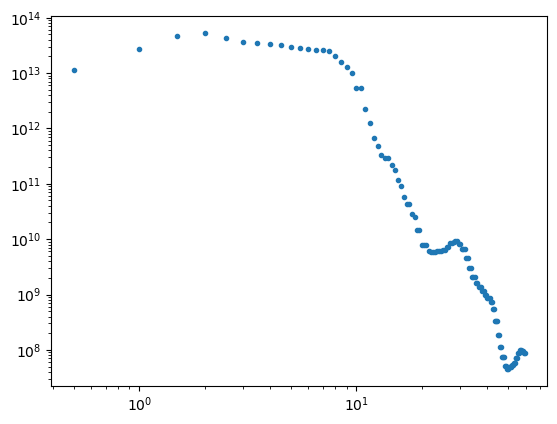

In [130]:
plt.plot(impact_param, C, '.')
plt.xscale("log")
plt.yscale("log")

In [10]:
mu = ad[('gas', 'mu')]


[('gas', 'mu'), ('ramses-rt', 'xHI'), ('ramses-rt', 'xHII')]
YTRegion (info_00203): , center=[2.31425819e+23 2.31425819e+23 2.31425819e+23] cm, left_edge=[0. 0. 0.] cm, right_edge=[4.62851637e+23 4.62851637e+23 4.62851637e+23] cm
0 :  <yt.utilities.cython_fortran_utils.FortranFile object at 0x2ab129f501e0>
0 :  6
0 :  1
0 :  24
0 :  {'ncpu': 192, 'ndim': 3, 'nx': array([3, 3, 3], dtype=int32), 'nlevelmax': 14, 'ngridmax': 800000, 'nboundary': 6, 'ngrid_current': 26540, 'boxlen': 150.0, 'nout': array([202, 203, 204], dtype=int32), 'tout': array([ 0.16759124,  0.33518247,  0.50277371,  0.67036495,  0.83795619,
        1.00554743,  1.17313866,  1.3407299 ,  1.50832114,  1.67591237,
        1.84350361,  2.01109485,  2.17868609,  2.34627732,  2.51386856,
        2.6814598 ,  2.84905104,  3.01664227,  3.18423351,  3.35182475,
        3.51941599,  3.68700722,  3.85459846,  4.0221897 ,  4.18978094,
        4.35737218,  4.52496341,  4.69255465,  4.86014589,  5.02773712,
        5.19532836,  5.3

AttributeError: 'yt.utilities.cython_fortran_utils.FortranFile' object has no attribute 'name'